# Vaccination Tweets: EDA, Sentiment Analyis

Agenda:
+ Frequency
    + most frequent words in tweets
    + look at most popular hashtags (in 'text' and in 'hashtags')
    + what is the most tweeted-about vaccine?
+ Time
    + Which vaccine "trends" in tweets? (time series)
    + Do different vaccines trend at different times as tweet subjects?

+ Sentiment
    + vaccine most closely connected to negative/positive sentiment
    + most influential sources who tweet positive/negative/neutral about vaccines in general
    + locations (uncleared) with the most positive, negative, neutral tweets
    + Positive, negative, neutral: which gets more retweets / are liked more?

(Measuring general attitude via tweets: how many people tweet by population, how many by population tweet about vaccines, how well are vaccinations monitored)

+ id:
+ user_name:
+ user_location: entered by user
+ user_description: entered by user
+ user_created: date of when the account was opened
+ user_followers: number of users which follow a specified user
+ user_friends: number of users which a specified user follows
+ user_favourites: 
+ user_verified: accounts of officially recognized organizations, users with many followers
+ date: date of tweet
+ text: text of the tweet
+ hashtags: hashtags user in the tweet
+ source: 
+ retweets: number of retweets
+ favorites:
+ is_retweet: whether the tweets is a retweet or not

Added:
+ day: 

In [66]:
df_tweety.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [104]:
# Main data packages. 
import numpy as np
import pandas as pd
from datetime import datetime

import pickle

#text processing, NLP modules
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
#plotting
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [15]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [162]:
df = pd.read_csv("Data/vaccination_tweets.csv")

In [163]:
df_tweety = df.copy()

In [164]:
shape = df_tweety.shape
print('The unmodified vaccination tweets dataset contains {} columns and {} rows.'.format(shape[1], shape[0]))

The unmodified vaccination tweets dataset contains 16 columns and 38547 rows.


In [165]:
#df_tweety.head()

In [166]:
df_tweety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38547 entries, 0 to 38546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                38547 non-null  int64 
 1   user_name         38547 non-null  object
 2   user_location     29767 non-null  object
 3   user_description  35940 non-null  object
 4   user_created      38547 non-null  object
 5   user_followers    38547 non-null  int64 
 6   user_friends      38547 non-null  int64 
 7   user_favourites   38547 non-null  int64 
 8   user_verified     38547 non-null  bool  
 9   date              38547 non-null  object
 10  text              38547 non-null  object
 11  hashtags          30330 non-null  object
 12  source            38514 non-null  object
 13  retweets          38547 non-null  int64 
 14  favorites         38547 non-null  int64 
 15  is_retweet        38547 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 4.2+ MB


In [167]:
df_tweety.describe().round(2)

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,3.854700e+04,38547.00,38547.00,38547.00,38547.00,38547.00
mean,1.365051e+18,109675.74,1309.57,15013.42,3.11,13.75
std,8.619936e+15,882398.75,6020.04,41677.98,33.87,184.20
min,1.337728e+18,0.00,0.00,0.00,0.00,0.00
25%,1.362003e+18,120.00,144.00,360.00,0.00,0.00
50%,1.366887e+18,577.00,417.00,2146.00,0.00,1.00
75%,1.371547e+18,2780.50,1189.00,11272.00,1.00,4.00
max,1.375348e+18,14906907.00,380428.00,1205878.00,2360.00,22815.00


In [168]:
df_tweety.isnull().sum()

id                     0
user_name              0
user_location       8780
user_description    2607
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            8217
source                33
retweets               0
favorites              0
is_retweet             0
dtype: int64

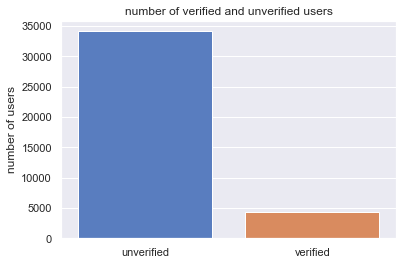

From 38547 accounts, 11.37% are verified twitter accounts.


In [169]:
sns.set_theme()
sns.set_palette('muted')
#Print users (verified/unverified), "verified" meaning that they are recognized to have some sort of official character
ax = sns.countplot(x='user_verified', data=df_tweety)
ax.set(xlabel='', ylabel='number of users', title='number of verified and unverified users')
plt.xticks(ticks=[False,True], labels=['unverified','verified'])
plt.show()
print(f'From {df_tweety.shape[0]} accounts, {round(df_tweety.user_verified.mean()*100, 2)}% are verified twitter accounts.')

In [170]:
#No tweets in this dataset appear to be retweets
df_tweety["is_retweet"].unique()

array([False])

In [171]:
#Insert column 'day' to map the vaccination progress data set
df_tweety['day'] = pd.to_datetime(df_tweety.date).dt.date

In [172]:
df_tweety.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
day                 object
dtype: object

## Dropping stuff(?)

In [173]:
#'user_location' is a highly diverse category
df_tweety.user_location.nunique()

8098

In [174]:
#The below mentioned columns should be dropped
df_tweety.drop(['id', 'user_created', 'user_location', 'is_retweet', 'source'], axis=1)

,user_name,user_description,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day
0,Rachel Roh,Aggregator of Asian American news; scanning di...,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0,0,2020-12-20
1,Albert Fong,"Marketing dude, tech geek, heavy metal & '80s ...",834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,1,1,2020-12-13
2,eli🇱🇹🇪🇺👌,"heil, hydra 🖐☺",10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0,0,2020-12-12
3,Charles Adler,"Hosting ""CharlesAdlerTonight"" Global News Radi...",49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,446,2129,2020-12-12
4,Citizen News Channel,Citizen News Channel bringing you an alternati...,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0,0,2020-12-12
...,...,...,...,...,...,...,...,...,...,...,...,...
38542,Rising Bharat,Bharat is Rising,625,0,0,False,2021-03-18 06:22:41,The Sputnik V is under review for emergency us...,NaN,1,7,2021-03-18
38543,Bright Uzbekistan,Bright Uzbekistan is a new International magaz...,18,182,59,False,2021-03-18 06:13:08,IT IS PLANNED TO START MASS VACCINATION IN UZB...,NaN,0,0,2021-03-18
38544,Sputnik V,Sputnik V is the world’s first registered COVI...,223700,142,678,True,2021-03-18 06:01:50,Austrian Chancellor Sebastian Kurz: Concerning...,['SputnikV'],83,226,2021-03-18
38545,Sputnik,"Sputnik is a global wire, radio and digital ne...",322326,306,24,True,2021-03-18 05:30:00,Norwegian politicians calling to cut #SputnikV...,['SputnikV'],6,16,2021-03-18


In [175]:
#There are duplicates in the text section, however, they ... check if source identical, there are no retweets, maybe duplicates should be removed in order to prevent imbalance
#df_tweety[(df_tweety.duplicated(subset=['text', 'user_name'], keep=False))]

In [176]:
#create dataframes for subcategories
#df = df_tweety[(df_tweety["user_followers"]>=10)]# & (df_tweety["user_verified"]==True)] (df_tweety["user_followers"]>=10)

In [177]:
# Users tweet repeptitively. About a third of users tweet repetitively. Assuming that their sentiment does not change, their sentiment is amplified.
(len(df_tweety) - df_tweety.user_name.nunique())/len(df_tweety)

0.4389187225983864

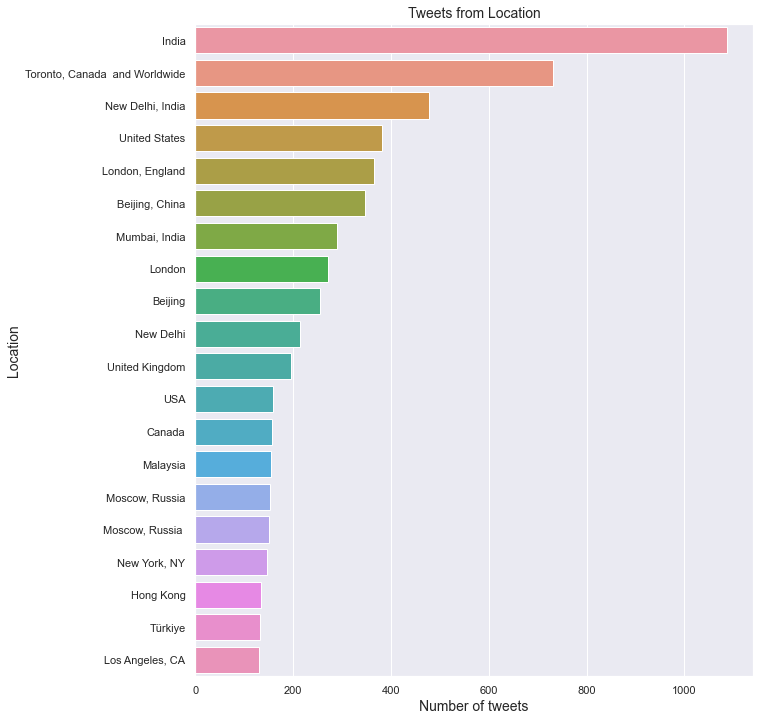

In [178]:
#user_location columns is very diverse
plt.figure(figsize=(10,12))
sns.barplot(df_tweety["user_location"].value_counts().values[0:20],
            df_tweety["user_location"].value_counts().index[0:20]);
plt.title("Tweets from Location",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Location",fontsize=14)
plt.show()

# Frequent words and hashtags

### A look at the most popular tweets

In [179]:
# Total tweets
print('Total tweets:', len(df_tweety.index), '\n')

# Retweets
df_tweety_stat1 = df.sort_values(by='retweets', ascending=False)
print('Mean retweets:', round(df_tweety_stat['retweets'].mean(),2), '\n')

print('10 most responded tweets')
print('------------------------')
df_tweety_stat1['text'].iloc[:10]

Total tweets: 38547 

Mean retweets: 3.11 

10 most responded tweets
------------------------


17118    Got my jab. For the curious, it was #Covaxin. ...
7126     New research published in Microbiology &amp; I...
24268    #Covaxin 🇮🇳 , made by Hyderabad-based Bharat B...
17543    Prime Minister Narendra Modi choose early morn...
38478    A batch of fake Sputnik V vaccines was confisc...
23715    This is not a queue for a Covid vaccine\nThis ...
20926    #BREAKING : Bharat Biotech says its #Covaxin s...
20536    It is tough when have to play the sauve Amrika...
13101    AIIMS nurse who gave the #Covaxin jab to Prime...
21527    The Opposition campaign to denigrate #Covaxin ...
Name: text, dtype: object

In [180]:
   
# Likes
df_tweety_stat2 = df.sort_values(by='user_favourites', ascending=False)
print('Mean likes:', round(df_tweety_stat2['user_favourites'].mean(),2), '\n')
print('10 most liked tweets')
print('--------------------')
df_tweety_stat2['text'].iloc[:10]

Mean likes: 15013.42 

10 most liked tweets
--------------------


10085    Profitti vaccinali #pfizer #moderna Insiders a...
32016    I just got my second #PfizerBiontech shot.  La...
31940    @thomaskaine5 I took the first available which...
32008    @pennyparker0523 @FLOTUS Fot #PfizerBioNtech s...
31965    Just for those curious:\n1st #PfizerBiontech a...
215      @jeremysale @nytimes Apparently the trucks are...
34383    .@zoemevorah Congrats on getting your vaccine ...
34106    First dose of #Moderna done!!!! #Mahalo #Longs...
31223    28 hrs post 2nd #moderna dose. Had a bad night...
30012    Received my 2nd #moderna vaccine today! @UNLV ...
Name: text, dtype: object

import requests
furl = 'https://spotleai.sgp1.digitaloceanspaces.com/course/data/tweets_bollywood.txt'
response = requests.get(furl)
tweets = response.text.split("\n")

raw = ' '.join(tweets)
tags = [re.sub(r"(\W+)$", "", j) for j in [i for i in raw.split() if i.startswith("#")]]
df_top = pd.DataFrame({"hashtag": tags})
fig, ax = plt.subplots()
plt.xlabel('Top trending Tweets')
df_top['hashtag'].value_counts().head(8).plot(ax=ax, kind='bar',figsize=(8,5))

### Most mentioned words in 'text'

In [181]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english') + ['i', 'the', 'get', '-', 'one']
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [182]:
tweet_words = []
for line in list(df_tweety['text']):
    words = line.split()
    for word in words:
        tweet_words.append(word.lower())
tweet_words=pd.Series(np.array(tweet_words))
frequency_ranking_words = tweet_words.value_counts()[:11].rename_axis('words_text_freq').reset_index(name='count')
#frequency_ranking_words

### Most frequent hashtags in 'text'

In [185]:
tweet_words_hasht = []
for line in df_tweety['text']:
    words = line.split()
    for word in words:
        if re.search('#[^\s]+', word):
            tweet_words_hasht.append(word)
tweet_words_hasht=pd.Series(np.array(tweet_words_hasht))
frequency_hashtags = tweet_words_hasht.value_counts()[:20].rename_axis('text_hasht_freq').reset_index(name='count')
frequency_hashtags

,text_hasht_freq,count
0,#Moderna,4980
1,#COVID19,3411
2,#Covaxin,3122
3,#PfizerBioNTech,2896
4,#SputnikV,2774
5,#vaccine,2622
6,#Sinopharm,1255
7,#OxfordAstraZeneca,1234
8,#CovidVaccine,1233
9,#Sinovac,1222


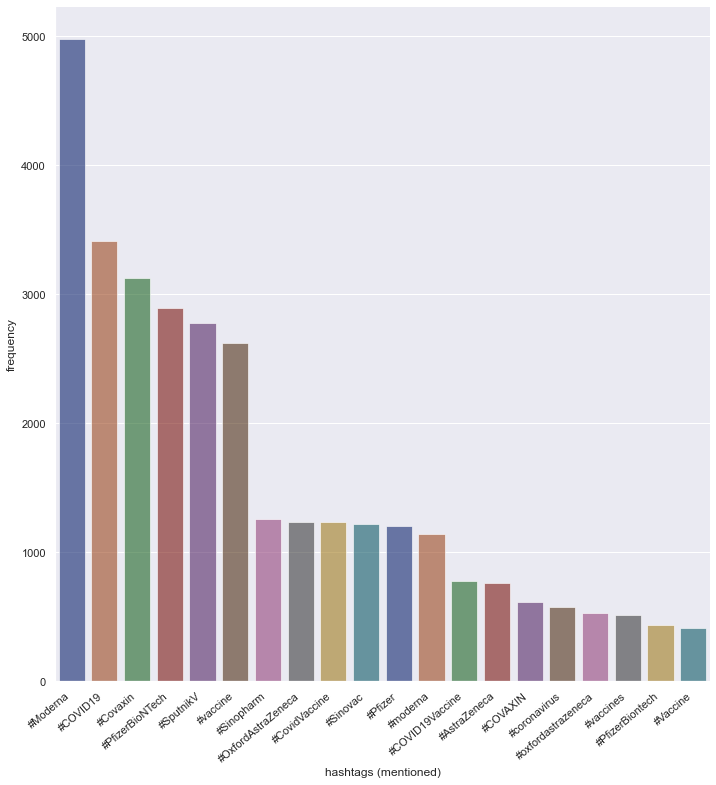

In [186]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=frequency_hashtags, kind="bar",
    x="text_hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hashtags (mentioned)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

### Most frequently mentioned twitter accounts

In [187]:
twitter_accounts = []
for line in df_tweety['text']:
    words = line.split()
    for word in words:
        if re.search('@[^\s]+', word):
            twitter_accounts.append(word)
mentioned_accounts=pd.Series(np.array(twitter_accounts))
accounts = mentioned_accounts.value_counts()[:20].rename_axis('accounts').reset_index(name='count')
accounts

,accounts,count
0,@narendramodi,724
1,@sputnikvaccine,385
2,@BharatBiotech,375
3,@PMOIndia,196
4,@pfizer,170
5,@POTUS,155
6,@fordnation,146
7,@Ocugen,140
8,@WHO,140
9,@MoHFW_INDIA,136


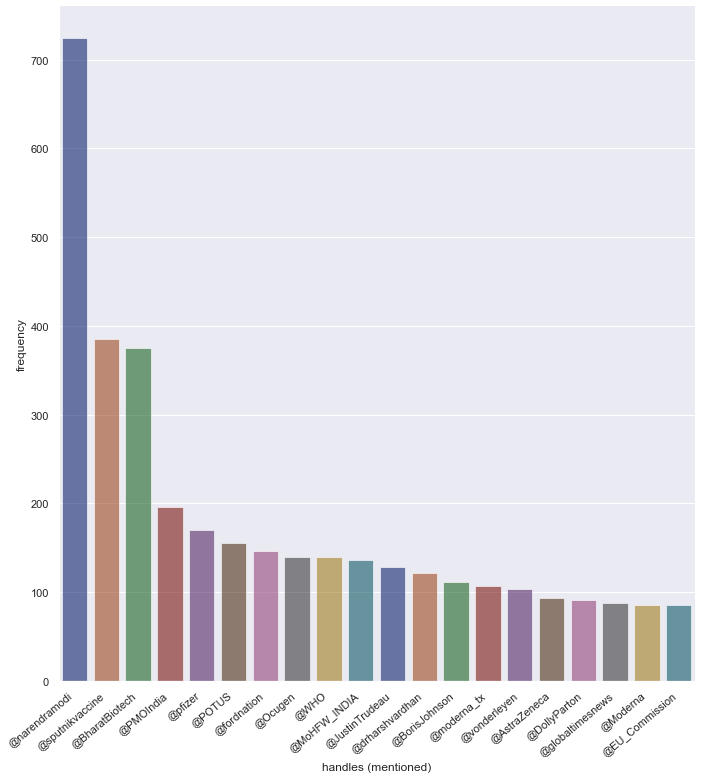

In [188]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=accounts, kind="bar",
    x="accounts", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("handles (mentioned)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

We see that politicians, political institutions and vaccine producers are the most requently mentioned twitter accounts. This points towards vaccination being regarded as a political topic beyond a scientific one. Therefore, any em

### Most frequent hashtags in 'hashtags'

In [189]:
df_tweety['hashtags'].value_counts()

['Moderna']                                                                    1653
['Covaxin']                                                                    1511
['SputnikV']                                                                   1231
['PfizerBioNTech']                                                              821
['OxfordAstraZeneca']                                                           557
                                                                               ... 
['impfluencer', 'PfizerBioNTech', 'PfizerCovidVaccine']                           1
['Moderna', '1PHASD']                                                             1
['PfizerBioNTech', 'reddit', 'jadorelargent', 'LPDLA8', 'TikTok', 'billie']       1
['OxfordAstraZeneca', 'vaccine', 'iom', 'iomgov', 'vaccines']                     1
['notthrowingawaymyshot', 'Moderna', 'georgiavaccine']                            1
Name: hashtags, Length: 14360, dtype: int64

Lists in 'hashtags' are stored as strings

In [41]:
#for i, l in enumerate(df_tweety['hashtags']):
    #print("list",i,"is",type(l))

lst_ = "['erst', 'zweit', 'dritt']"

def clean_hashtag(name):
    name = name.replace("[", "")
    name = name.replace("]", "")
    name = name.replace("'", "")
    name_lst = name.split(",")
    hash_lst = list()
    for item in name_lst:
        item = item.strip()
        hash_lst.append(item)
    return hash_lst

In [191]:
df_tweety['hashtags'] = df_tweety['hashtags'].apply(eval)

In [192]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

hasht_freq = to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_freq').reset_index(name='count')
hasht_freq

,hasht_freq,count
0,moderna,7021
1,covaxin,4860
2,covid19,4689
3,pfizerbiontech,3859
4,vaccine,3598
5,sputnikv,3363
6,oxfordastrazeneca,1934
7,covidvaccine,1820
8,pfizer,1758
9,sinovac,1591


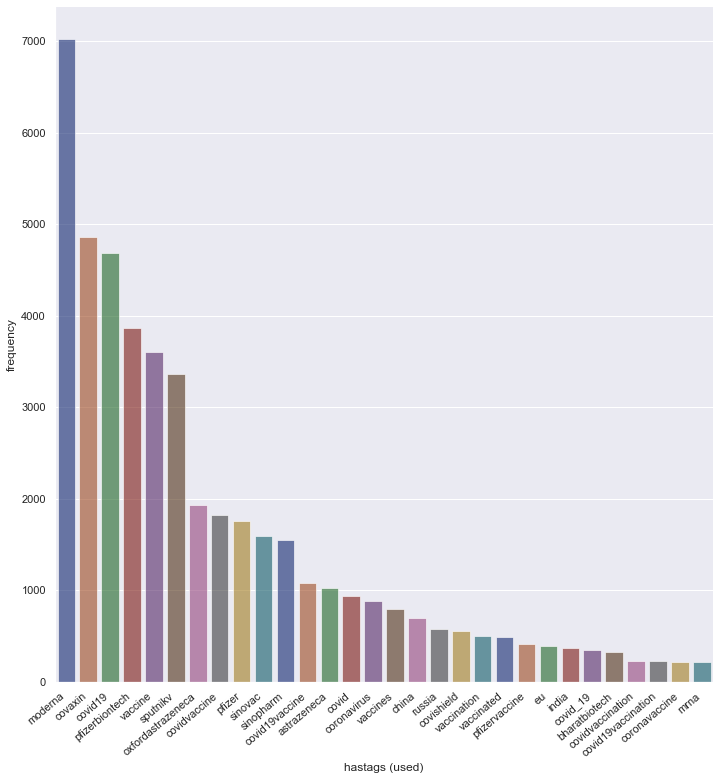

In [193]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=hasht_freq, kind="bar",
    x="hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hastags (used)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

In contrast, particular vaccines or the vaccination topic play the dominant role in the category of used hashtags. Politicians or institutions do not figure prominently in this category.

### Most mentioned countries in 'hashtags'
We can however spot that countries get mentioned in used hashtags. China, Russia, India and the EU trend at the top. This might be relevant to compare with vaccination progress in these countries.

In [194]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x for lst in Series for x in lst if x in ['China', 'EU', 'India', 'USA', 'Russia', 'UK', 'Italy', 'Germany', 'France', 'America', 'Brazil', 'Japan', 'Canada', 'Afghanistan', 'china']])

to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_country_freq').reset_index(name='count')

,hasht_country_freq,count
0,China,670
1,Russia,568
2,EU,361
3,India,339
4,Italy,97
5,Canada,94
6,UK,92
7,USA,70
8,Brazil,68
9,Germany,65


### overtweeted (one tweet several times)

In [195]:
repeated_tweets = []
for i in range(len(df_tweety['text'])):
    repeated_tweets.append(df_tweety['text'][i])
repeated_tweets=pd.Series(np.array(repeated_tweets))
#list_of_words

frequency_ranking_tweets = repeated_tweets.value_counts()[:30].rename_axis('overtweeted').reset_index(name='count')
#frequency_ranking_tweets

### Create df with hashtags as columns and boolean values

Idea: create df with vaccines in hashtags as columns and append it to df_tweety

In [196]:
def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

unique_hasht = to_1D(df_tweety['hashtags']).value_counts()[:20]
unique_hasht

moderna              7021
covaxin              4860
covid19              4689
pfizerbiontech       3859
vaccine              3598
sputnikv             3363
oxfordastrazeneca    1934
covidvaccine         1820
pfizer               1758
sinovac              1591
sinopharm            1547
covid19vaccine       1072
astrazeneca          1023
covid                 932
coronavirus           877
vaccines              789
china                 699
russia                580
covishield            555
vaccination           498
dtype: int64

In [197]:
def boolean_df(item_lists, unique_items):

    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask that returns a True-False list of whether a tag is in a taglist
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [198]:
hasht_bool = boolean_df(df_tweety['hashtags'], unique_hasht.keys())

In [199]:
hasht_bool
#to do: drop some! for investigation, take conjunctions of e.g. pfizerbiontech and pfizer etc.
#hasht_bool.drop(['id', 'user_created', 'user_location', 'is_retweet', 'source'], axis=1)
hasht_bool.nunique()

moderna              2
covaxin              2
covid19              2
pfizerbiontech       2
vaccine              2
sputnikv             2
oxfordastrazeneca    2
covidvaccine         2
pfizer               2
sinovac              2
sinopharm            2
covid19vaccine       2
astrazeneca          2
covid                2
coronavirus          2
vaccines             2
china                2
russia               2
covishield           2
vaccination          2
dtype: int64

# Cleaning 'text' (round 1)

### Various removals, lowercase()

def CleanTweet(x):
    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub(r'\B#\S+','',x)
    #remove urls
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove special characters
    x = re.findall(r'\w+', x)
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    return x

In [200]:
#df_tweety.text = df_tweety.text.apply(CleanTweet)

In [201]:
#remove twitter handlers
df_tweety.text = df_tweety.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#remove URLs
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x))

#remove punctuation
df_tweety.text = df_tweety.text.apply(lambda x:x.replace('[^\w\s]',''))

#remove special characters
df_tweety.text = df_tweety.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) #re.sub('[^A-Za-z0-9]+', '', x)

#remove single characters
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#substitute multiple spaces with single space
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#lowercase
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word.lower() for word in x.split()]))

#remove numbers from words
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('\w*\d\w*', '', x))

#remove
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('\n', '', x))

#remove
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('[''""_/]', '', x))

# Feature engineering 'text'

### stopwords, stemming, lemmatizing

In [202]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [225]:
#tokenize
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word_tokenize(word) for word in x.split() ]))

In [204]:
# stemming 
stemmer = PorterStemmer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

In [205]:
# lemmazation
lemmatizer = WordNetLemmatizer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() ]))

Try to turn abbreviations into regular strings

In [206]:
import csv

#helper function to turn abbreviations into words and delete slang
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "/Users/JDSeo/Desktop/Daily-Neural-Network-Practice-2/NLP/cleaning/slang.txt"
        with open(fileName, "r") as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9]+', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    return ' '.join(user_string)

# First sentiment analysis (VADER)

In [232]:
!pip install vaderSentiment

In [233]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [240]:
analyser = SentimentIntensityAnalyzer()

scores=[]
for i in range(len(df_tweety['text'])):
    
    score = analyser.polarity_scores(df_tweety['text'][i])
    score=score['compound']
    scores.append(score)
    
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('positive')
    elif i<=(-0.05):
        sentiment.append('negative')
    else:
        sentiment.append('neutral')

df_tweety['sentiment']=pd.Series(np.array(sentiment))

# Create some sub-dataframes

### single out most popular users and their tweets (and tweet sentiments)

Identify whether the most popular users tweet predominantly positively, negatively or neutrally. Is it possible to see, how their followers tweet? Is there a mutual influence?

In [248]:
df_tweety.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'day', 'sentiment'],
      dtype='object')

In [249]:
twinfluence1 = df_tweety.sort_values("user_followers", ascending=False)

### Look at the influence by 'user_follower' and display balance of tweet sentiments

<AxesSubplot:xlabel='user_followers', ylabel='user_name'>

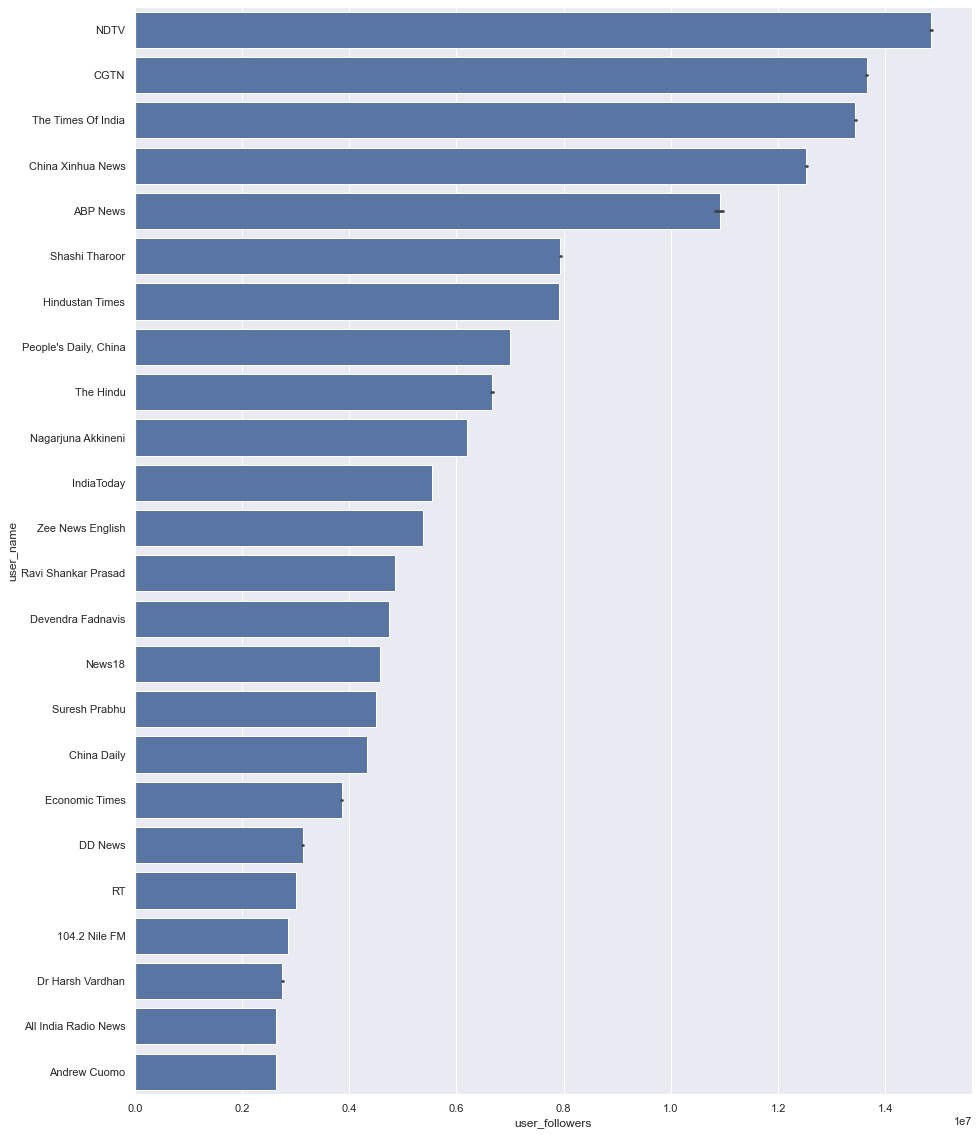

In [255]:
f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='user_followers', y='user_name', orient='h', color='b', data=twinfluence1[['user_name', 'user_followers']][:400])

<AxesSubplot:xlabel='user_followers', ylabel='user_name'>

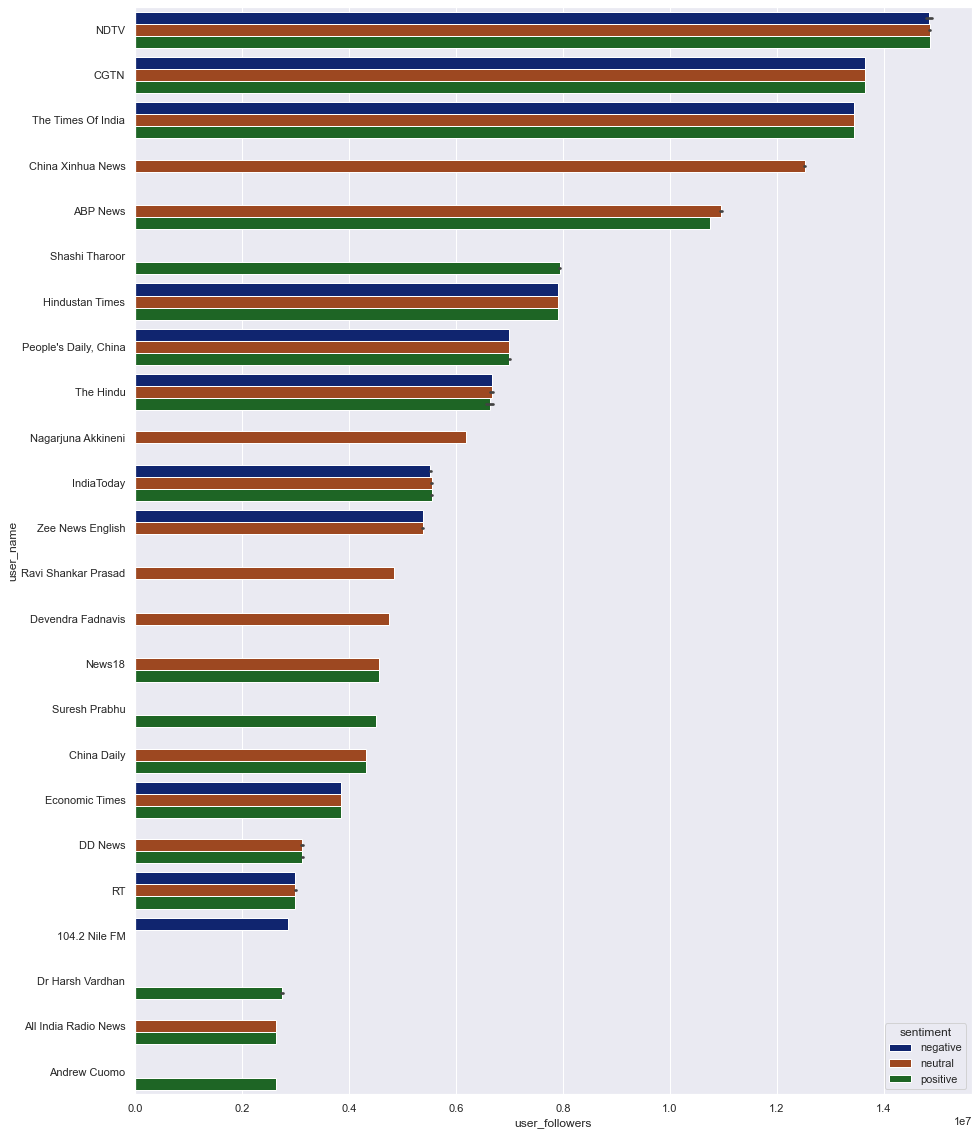

In [251]:
f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='user_followers', y='user_name', hue='sentiment', orient='h', palette="dark", data=twinfluence1[['user_name', 'user_followers', 'sentiment']][:400])

In [57]:
# delete multiples for certain purposes! Written

### Look at most retweeted tweets and display balance of tweet sentiments

<AxesSubplot:xlabel='retweets', ylabel='user_name'>

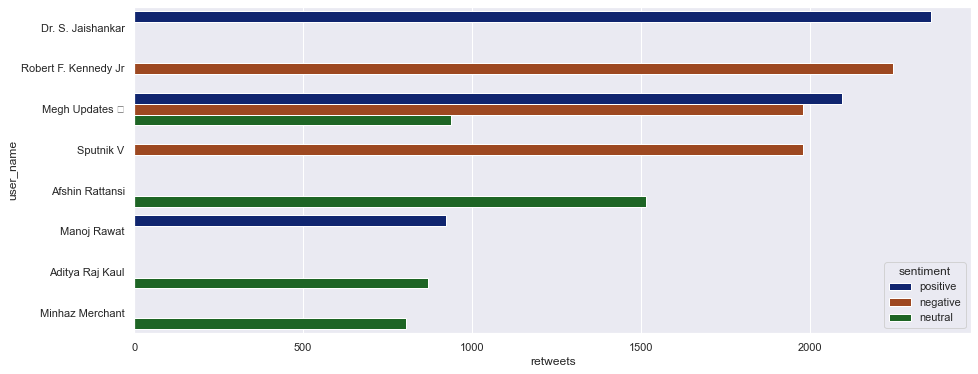

In [245]:
twinfluence2 = df_tweety.sort_values("retweets", ascending=False)

f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='retweets', y='user_name', orient='h', palette="dark", hue='sentiment', data=twinfluence2[['retweets', 'user_name', 'sentiment']][:10])

### Look at the influence by 'user_favourites' and display tweet sentiments

<AxesSubplot:xlabel='user_favourites', ylabel='user_name'>

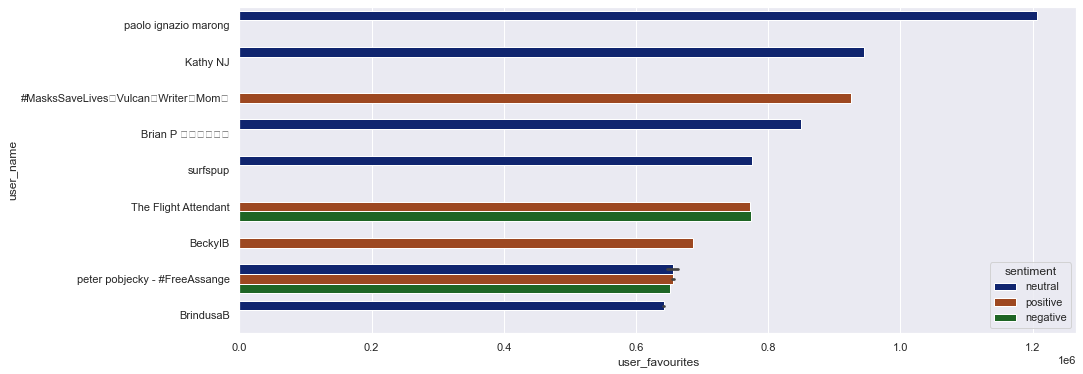

In [247]:
twinfluence3 = df_tweety.sort_values("user_favourites", ascending=False)

f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='user_favourites', y='user_name',  hue='sentiment', orient='h', palette="dark", data=twinfluence3[['user_name', 'user_favourites', 'sentiment']][:20])